In [1]:
# common imports
import numpy as np
import pandas as pd
import os, cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# global variables
ROWS = 200
COLUMNS = 200
CHANNELS = 3
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
sns.set(style="whitegrid")  # for plots

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples.
* Each sample is a colored image (JPEG file) of a dog or a cat. The image sizes vary, so they need to be scaled to the same size.
* The data contains two labels (mentioned in each image file's name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.


# 1. Getting the Data

In [2]:
train_path = r"dogs-vs-cats\train/"

train_images = [train_path + i for i in os.listdir(train_path)]
# listdir returns a list with the file names in the given directory

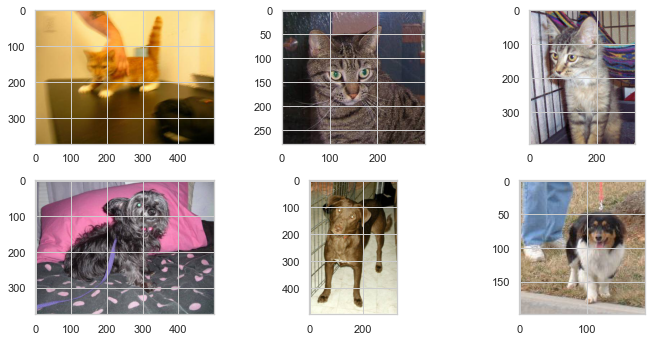

In [3]:
fig = plt.figure(figsize=(10,7))

for i in range(6):
    plt.subplot(330+i+1)
    if i < 3:
        filename = train_path + 'cat.' + str(i) + '.jpg'
    else:
        filename = train_path + 'dog.' + str(i-3) + '.jpg'
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

In [4]:
def image_shape(image_path):
    return cv2.imread(image_path).shape

def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return shapes

In [5]:
image_shapes = load_data_shapes(train_images)

KeyboardInterrupt: 

In [ ]:
image_res_df = pd.DataFrame(image_shapes, columns=['height', 'width', 'n_channels'])
image_res_df.head(3)

In [ ]:
image_res_df.n_channels.unique()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.2)
ax1.set_title("Original", size=15)
points = ax2.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height", size = 15)
ax2.set_xlim(xmin=50, xmax=510)
ax2.set_ylim(ymin=50, ymax=510)
ax2.set_title("Zoomed", size=15)
ax2.set_xlabel("width")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

> Observations:
>> * Most image resolutions are less than 500 by 500. There is also a fair amount around 400x400,
>> 300x300, and 200x200.
>> * Rescaling the images to 200x200 seems to be the best option for maintainable amount of features
>> that also reflects the data.
>> * After rescaling, the number of features will be 200x200x3 = 120,000.
>
> Note: The global variables (instantiated below the imports) have been set to these values.

> Why was this necessary?
>
> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
> The following functions do just that:

In [ ]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    m = len(images)
    n_x = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_x), dtype=np.uint8)
    y = np.zeros((m, 1))

# i is the count of the current iteration
# image_file is the path of the image file at the current iteration
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        X[i, :] = np.squeeze(image.reshape((n_x, 1))) # squeeze removes useless one-dimensional arrays
        if '/dog' in image_file:
            y[i, 0] = 1
        elif '/cat' in image_file:
            y[i, 0] = 0
        else:
            y[i, 0] = image_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y

In [ ]:
X, labels = prep_data(train_images)

In [ ]:
X

In [ ]:
labels

In [ ]:
# create a DataFrame including a column for labels
df = pd.concat([pd.DataFrame(labels, columns=['label']), pd.DataFrame(X)], axis=1)
df.head()

In [ ]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()

In [ ]:
# for i in range(11):
   # show_images(X, labels, i)

In [ ]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [ ]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3].drop('label', axis = 1)
sample0

In [ ]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3].drop('label', axis = 1)
sample1

In [ ]:
df['label'].value_counts()

> Observations:
> * By looking at the index numbers for each group, the first instance labeled 1 (dog) is located at index 12500.
> My assumption was that all cat images were the first 12,500 samples, with the rest as dogs.
> To validate my assumptions I counted the values for each class.
> * Why is this important? Data arranged by class order could result in poor performance of the ML algorithms,
> an unrepresentative test set or cross-validation folds later on (i.e., a test set containing only cat images).
> * Solution: The train_test_split() is a random sampling method, so it takes care of this.
> The random_state parameter ensures that the generated shuffled split is the same each time.

In [ ]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

In [ ]:
fig = plt.figure(figsize=(10,7))
rows = 2
columns = 3

# add sample image in each iteration
for i in range(rows*columns):
    image = sample_images[i:i+1].to_numpy().reshape((ROWS, COLUMNS, CHANNELS))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
fig.suptitle("Dogs vs. Cats Samples", size=30)
plt.tight_layout()
plt.show()

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [ ]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)